#Part 1: Data Cleaning and Aggregation

In [1]:
#!pip install lightning
#import lightning as L
import torch
import torch.nn.functional as F
#import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms


In [2]:
# standard libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os


#!pip install mlxtend
# ML/stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#seaborn
import seaborn as sns

import seaborn as sns


# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.colors as mcolors

# apply some cool styling
from matplotlib import rcParams
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

from operator import attrgetter


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
transactions = pd.read_csv('/content/drive/MyDrive/Advent Interview/qsr_case_study_transactions_20230504.csv')
descriptions = pd.read_csv('/content/drive/MyDrive/Advent Interview/qsr_case_study_descriptions_20230504.csv')
users = pd.read_csv('/content/drive/MyDrive/Advent Interview/qsr_case_study_users_20230504.csv')
merchants = pd.read_csv('/content/drive/MyDrive/Advent Interview/qsr_case_study_merchants_20230504.csv')

In [5]:
print(len(transactions) == len(descriptions))
len(transactions)

True


7924087

In [6]:
#example basic cleaning for one table

#transactions.head()
#transactions.isnull().sum()

#### Cleaning to search for missing values

In [7]:
#merging all of the datasets into one large file, merged

merged = transactions.merge(descriptions, on = "item_id")
merged = merged.merge(users, on = "user_id")
merged = merged.merge(merchants, on = 'merchant_id' )

We can see in the below code the following things in our dataset:
*   There are 207204 unique users(customers) in our dataset
*   There are 3476533 unique orders in our dataset
  * There are 16068 less orders, indicating that it is likely order totals are the same for each item in the order
* There are  7924087 line items in our dataset
* There are 10 states in our dataset







In [8]:
merged.nunique(axis=0)

user_id                   207204
order_id                 3476533
merchant_id                   10
order_date                  1461
item_id                  7924087
item_quantity                 94
item_price                  6934
tax                         4401
shipping_cost               1208
order_discount              2210
order_total                16068
description               666067
state_name                    10
zip_code                   10084
gender_name                    2
mob                           88
ethnicity_name                 5
education_name                 5
household_income_name         12
merchant_name                 10
dtype: int64

In [9]:
merged.isnull().sum()

user_id                        0
order_id                       0
merchant_id                    0
order_date                     0
item_id                        0
item_quantity                  0
item_price               1298913
tax                       760104
shipping_cost            6565292
order_discount           6242692
order_total                    0
description               734648
state_name                     0
zip_code                       0
gender_name               256454
mob                            0
ethnicity_name            183647
education_name              1178
household_income_name          0
merchant_name                  0
dtype: int64

In [10]:
#merged.dtypes

In [12]:
merged['quarter'] = pd.to_datetime(merged['order_date']).dt.to_period('Q')



In [13]:
merged.head()

,user_id,order_id,merchant_id,order_date,item_id,item_quantity,item_price,tax,shipping_cost,order_discount,...,description,state_name,zip_code,gender_name,mob,ethnicity_name,education_name,household_income_name,merchant_name,quarter
0,ecdc60b4-1213-32b0-81cb-2896ec4f0eab,4efd00e3-55dd-31ce-8887-3f53a4a32b15,1712,2022-05-23,4275544f-e518-3d65-9a7b-a94f458a2a26,1,6.89,1.61,NaN,NaN,...,Cream of Chicken & Wild Rice Soup,TX,75402,F,198601,NonHwhite,SomeCollege,1-15k,PaneraBread,2022Q2
1,ecdc60b4-1213-32b0-81cb-2896ec4f0eab,700b4d41-d6cb-3754-b4e0-86bbc27f46b5,1712,2020-10-29,7f8907ef-150a-37e7-a039-9c43700402ca,1,2.49,0.85,NaN,NaN,...,Chocolate Chipper Cookie,TX,75402,F,198601,NonHwhite,SomeCollege,1-15k,PaneraBread,2020Q4
2,ecdc60b4-1213-32b0-81cb-2896ec4f0eab,63cf4a79-9607-3e3c-baff-80488ee71692,1712,2021-05-03,68311428-ddc5-38c8-b262-1e37ed113786,1,2.49,0.94,NaN,NaN,...,Chocolate Chipper Cookie,TX,75402,F,198601,NonHwhite,SomeCollege,1-15k,PaneraBread,2021Q2
3,ecdc60b4-1213-32b0-81cb-2896ec4f0eab,63cf4a79-9607-3e3c-baff-80488ee71692,1712,2021-05-03,42df3966-926c-3478-93b5-db2a280fb9df,1,8.89,0.94,NaN,NaN,...,Pepperoni Flatbread Pizza,TX,75402,F,198601,NonHwhite,SomeCollege,1-15k,PaneraBread,2021Q2
4,ecdc60b4-1213-32b0-81cb-2896ec4f0eab,40cd876b-9dee-3d71-824e-462402cf863a,1712,2022-09-12,f06a33b3-5cfe-3c9a-b184-369702f5c25c,1,13.48,1.39,NaN,NaN,...,The Spicy Take Chicken Sandwich,TX,75402,F,198601,NonHwhite,SomeCollege,1-15k,PaneraBread,2022Q3


In [ ]:
merged['merchant_name'].hist()

In [ ]:
merged['state_name'].hist()

#Part 2: Overall Metrics

In [16]:
#Create a restaurant object each time so code is not redundant.
#Restaurant object compiles  primary functions for first part of the analysis
class RestaurantAnalysis():

  def __init__(self, data):
    self.data = data
    self.length = len(data)

  def pivot(self, data, index = "merchant_name", columns = "quarter", values = "order_total" ):
    #helper function that turns data into pivots for excel
    return data.pivot(index="merchant_name", columns="quarter", values="order_total").fillna(0)

  def quarterly_orders(self, data, reset_index = True):
    #helper function for common group by
    orders = data.groupby(["merchant_name", "quarter","order_id"])[['order_total']].mean()
    if reset_index:
        orders = orders.reset_index()[['merchant_name','quarter','order_total']]
    return orders

  def avg_order_value(self):
    #average order Value
    avg_order = self.quarterly_orders(self.data)
    avg_order = avg_order.groupby(["merchant_name", "quarter"])[['order_total']].mean().reset_index()
    avg_order = self.pivot(data = avg_order)
    return avg_order

  def median_order_value(self):
    #median order value
    median_order = self.quarterly_orders(self.data)
    median_order = median_order.groupby(["merchant_name", "quarter"])[['order_total']].median().reset_index()
    median_order = self.pivot(data = median_order)
    return median_order

  def revenue_market_share(self):
    #Revenue market Share. Returns market share and total makrket
    rev_market_share = self.quarterly_orders(self.data,False)
    rev_market_share = rev_market_share.groupby(["merchant_name", "quarter"])[['order_total']].sum() \
                     .groupby(level=1, group_keys=False).apply(lambda x: x/float(x.sum())).reset_index()
    rev_market_share = self.pivot(data = rev_market_share)

    total_market = self.data.groupby(["quarter","order_id"])[['order_total']].mean().reset_index() \
                              .groupby(["quarter"])[['order_total']].sum().T
    return rev_market_share, total_market

  def order_market_share(self):
    #Order market share. Returns market share and total makrket
    ord_market_share = self.data.groupby(["merchant_name", "quarter"])[['order_id']].nunique()
    ord_market_share = ord_market_share.groupby(level=1,group_keys = False).apply(lambda x: x/float(x.sum())).reset_index().pivot(
    index="merchant_name", columns="quarter", values="order_id")

    total_market = self.data.groupby(["quarter"])['order_id'].nunique().reset_index() \
                            .groupby(["quarter"])[['order_id']].sum().T

    return ord_market_share, total_market

  def total_orders(self):
    #gets the total number of orders per merchant
    num_orders = self.data.groupby(["merchant_name", "quarter"])['order_id'].nunique().reset_index().pivot(index="merchant_name", columns="quarter", values="order_id").fillna(0)

    return num_orders

  def total_customers(self):
    # gets the total number of customers per merchant
    num_customers = self.data.groupby(["merchant_name", "quarter"],group_keys=False)["user_id"].nunique().reset_index().pivot(index = "merchant_name", columns = "quarter", values = "user_id").fillna(0)
    return num_customers

  def cohort_analysis(self):
    #asists in cohort analysis
    df = self.data.groupby(['merchant_name','cohort', 'quarter']) \
                .agg(n_customers=('user_id', 'nunique')).reset_index()
    df['period_number'] = (df.quarter - df.cohort).apply(attrgetter('n'))
    df = df.pivot_table(index = 'cohort',
                          columns = 'period_number',
                          values = 'n_customers')
    return df



In [17]:
main_df = RestaurantAnalysis(merged)




In [18]:
main_df.avg_order_value()

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.000000,0.000000,0.000000,8.909273,10.208344,13.659453,11.991401,12.484146,13.181397,12.236078,12.454062,12.793786,13.216450,12.915154,12.871297,13.039936
Chipotle,18.258749,17.887881,17.811447,18.266827,19.092063,20.968337,20.316852,21.021150,21.699825,21.594643,21.629075,21.706787,22.456099,22.815026,22.920175,23.702085
Dunkin Donuts,15.195228,15.410877,15.294875,15.315518,15.121293,15.651061,15.667849,15.717786,15.516379,15.600918,15.553553,15.829744,15.686620,15.954509,15.762984,15.906656
Jimmy John's,18.354651,17.804716,17.529439,16.647765,16.714429,19.444855,18.082917,18.308541,18.813043,19.602310,20.257404,20.483595,20.746592,22.029354,21.438497,22.233572
PaneraBread,20.759973,20.922246,21.158645,20.936344,21.646988,24.276899,21.787126,22.464766,22.468105,22.354154,22.594952,23.043155,23.181125,22.153290,22.726676,23.305199
Shake Shack,21.352294,21.941789,20.520059,20.581365,22.676001,28.452694,26.461645,26.397220,27.402955,26.861493,26.244174,27.408089,26.990591,28.550791,28.134748,30.709762
Subway,11.983547,12.583587,12.763079,12.529405,11.967017,13.512886,14.427437,15.268337,15.158671,15.121774,15.581777,15.647814,15.765758,16.015291,16.774701,16.576949
Sweetgreen,15.583864,15.968021,15.495653,15.679334,16.688953,23.324056,21.924201,21.840897,21.780579,22.303002,21.899077,21.845280,22.800198,22.969146,22.538833,21.539855
Taco Bell,13.353217,12.927082,13.553883,13.477918,13.996135,16.697729,15.286847,15.397934,14.785599,14.004377,13.884208,14.003156,14.658196,15.014872,14.699025,15.513337


In [19]:
main_df.median_order_value()

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.000,0.000,0.000,6.500,7.52,11.550,9.37,9.74,10.78,9.89,10.38,10.34,9.85,9.73,9.72,10.050
Chipotle,15.040,14.650,14.510,14.940,16.04,18.130,17.58,18.00,18.56,18.19,18.07,18.09,18.76,18.94,18.73,19.420
Dunkin Donuts,10.000,10.000,10.000,10.000,10.00,10.000,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.000
Jimmy John's,14.330,14.325,13.890,12.940,13.13,16.135,14.66,14.91,15.30,15.61,16.00,16.12,16.72,17.23,17.03,17.580
PaneraBread,14.660,14.690,14.715,14.910,15.24,20.990,18.17,18.50,18.43,17.85,17.87,17.89,18.00,17.08,17.46,18.000
Shake Shack,16.830,17.280,16.185,16.930,18.82,25.490,22.89,22.89,24.19,22.95,22.34,23.12,22.74,23.34,23.41,25.610
Subway,9.290,9.900,9.980,9.975,9.78,10.830,11.89,14.48,12.54,12.69,12.63,13.18,12.70,12.96,13.76,13.790
Sweetgreen,13.880,13.880,13.880,13.880,14.10,18.850,17.64,17.96,17.64,17.37,16.82,16.68,17.03,17.37,16.82,16.280
Taco Bell,10.875,10.540,11.100,10.760,11.11,13.810,12.60,12.78,12.07,11.28,11.36,11.38,11.91,12.07,11.89,12.395


In [20]:
rev_main = main_df.revenue_market_share()
rev_main[0]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.000000,0.000000,0.000000,0.004348,0.016116,0.024944,0.021167,0.017456,0.019720,0.019786,0.020097,0.025488,0.025287,0.026322,0.025936,0.026555
Chipotle,0.185068,0.227885,0.233190,0.246336,0.312485,0.443991,0.346982,0.331436,0.338079,0.316316,0.291987,0.285045,0.303954,0.276958,0.274761,0.260396
Dunkin Donuts,0.242407,0.253579,0.256108,0.232619,0.183001,0.126506,0.163614,0.160679,0.146514,0.170513,0.173376,0.168061,0.150779,0.170937,0.144397,0.152885
Jimmy John's,0.049283,0.042997,0.042141,0.044094,0.043889,0.034320,0.032281,0.030222,0.043749,0.058344,0.058653,0.054286,0.057632,0.059356,0.060285,0.055990
PaneraBread,0.347412,0.294758,0.291471,0.298631,0.248436,0.179352,0.199890,0.209933,0.186585,0.166540,0.165798,0.175528,0.169797,0.165612,0.177317,0.206597
Shake Shack,0.027692,0.028077,0.023581,0.024254,0.023882,0.037443,0.034651,0.034213,0.031298,0.028438,0.024856,0.025504,0.022470,0.021971,0.022590,0.025601
Subway,0.023818,0.032474,0.034628,0.038919,0.055597,0.076698,0.071773,0.054171,0.046207,0.051994,0.051281,0.051611,0.056673,0.062681,0.065002,0.054415
Sweetgreen,0.090252,0.091397,0.088528,0.076979,0.079169,0.033579,0.043830,0.040154,0.037607,0.043725,0.044868,0.042070,0.047939,0.047840,0.046624,0.042568
Taco Bell,0.034068,0.028833,0.030354,0.033820,0.037425,0.043167,0.046877,0.046403,0.052542,0.054978,0.056976,0.056078,0.050508,0.058316,0.061034,0.069283


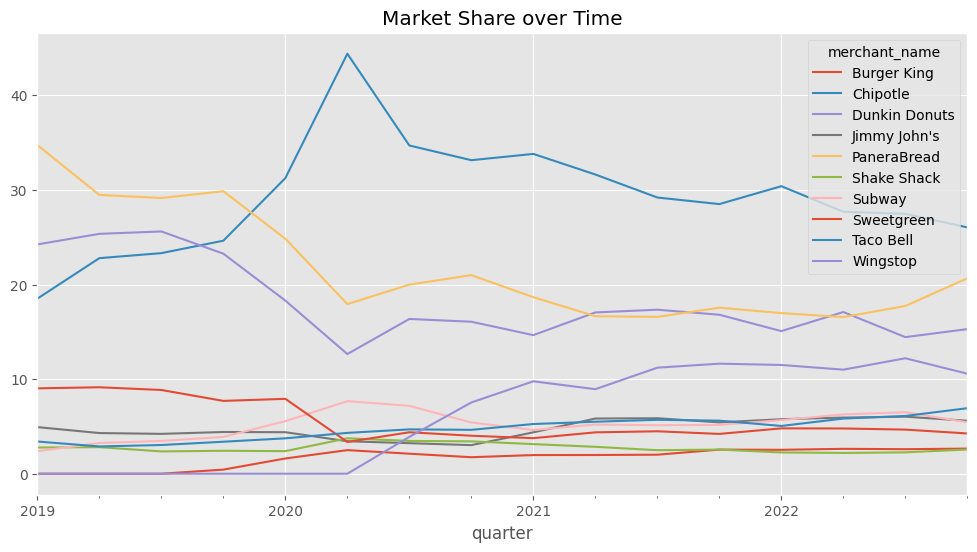

In [21]:
### Market Share of All Companies


pivot = rev_main[0].T*100
mktshre = pivot.plot.line(title = 'Market Share over Time')
#mktshre.title("Market Rate over Time", )

# Plotting
#plt.figure(figsize=(10, 6))



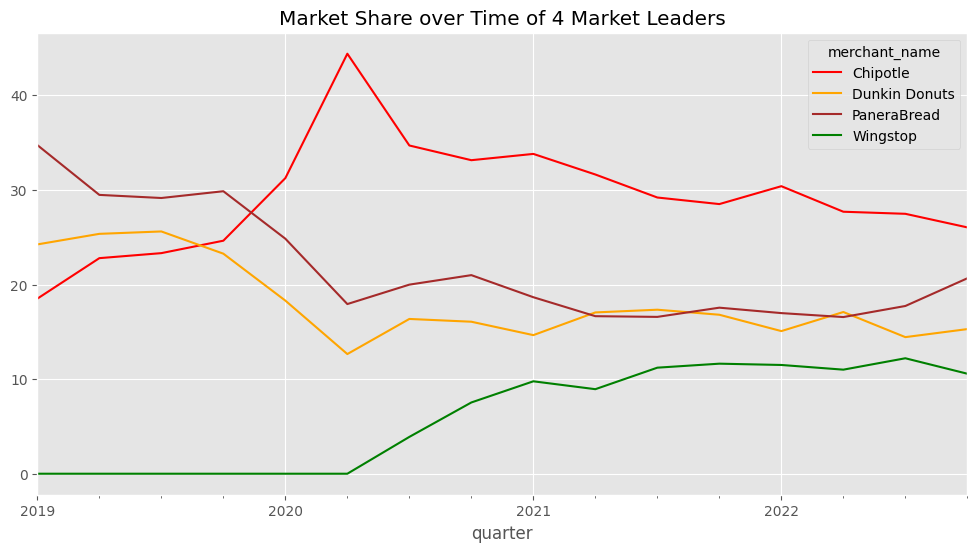

In [22]:
### Market Share of Top Competiotors

leaders = rev_main[0].iloc[[1, 2, 4, 9]].T*100
mktshre = leaders.plot.line(title = 'Market Share over Time of 4 Market Leaders', color={"Chipotle": "red", "Dunkin Donuts": "orange", "PaneraBread": "Brown", "Wingstop": "Green"})

In [23]:
#answers quarterly revenue question on excel

rev_main[1]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
order_total,1599966.6,1913084.96,1921384.81,2001787.59,2329157.26,3596615.45,4265760.46,4579885.62,5243712.39,5820499.1,5729068.72,5724813.46,5732048.96,6124494.02,5847473.46,5651093.08


In [24]:
#answers order market share question on excel

main_df.order_market_share()[0]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,NaN,NaN,NaN,0.008447,0.027567,0.035630,0.033325,0.027557,0.029983,0.031679,0.031883,0.039929,0.039222,0.041366,0.041394,0.042328
Chipotle,0.177400,0.221513,0.226385,0.233402,0.285804,0.413135,0.322423,0.310728,0.312233,0.286960,0.266721,0.263194,0.277475,0.246389,0.246257,0.228352
Dunkin Donuts,0.279210,0.286108,0.289544,0.262876,0.211328,0.157706,0.197145,0.201467,0.189237,0.214117,0.220237,0.212789,0.197043,0.217461,0.188179,0.199777
Jimmy John's,0.046994,0.041990,0.041569,0.045842,0.045852,0.034437,0.033701,0.032532,0.046604,0.058309,0.057206,0.053118,0.056946,0.054688,0.057765,0.052343
PaneraBread,0.292895,0.244963,0.238202,0.246872,0.200405,0.144144,0.173207,0.184169,0.166428,0.145950,0.144977,0.152673,0.150157,0.151734,0.160275,0.184259
Shake Shack,0.022699,0.022249,0.019871,0.020396,0.018390,0.025676,0.024722,0.025543,0.022889,0.020740,0.018712,0.018650,0.017066,0.015619,0.016494,0.017328
Subway,0.034786,0.044872,0.046915,0.053761,0.081126,0.110743,0.093917,0.069921,0.061089,0.067359,0.065024,0.066107,0.073691,0.079438,0.079602,0.068229
Sweetgreen,0.101362,0.099523,0.098789,0.084974,0.082835,0.028090,0.037742,0.036232,0.034603,0.038407,0.040480,0.038599,0.043102,0.042274,0.042494,0.041077
Taco Bell,0.044654,0.038782,0.038725,0.043429,0.046692,0.050440,0.057892,0.059392,0.071217,0.076908,0.081077,0.080265,0.070637,0.078831,0.085297,0.092828


In [25]:
#answers total order question on excel
main_df.total_orders()

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.0,0.0,0.0,977.0,3677.0,6568.0,7530.0,6404.0,7845.0,9412.0,9245.0,11405.0,10967.0,12482.0,11783.0,11508.0
Chipotle,16217.0,24372.0,25155.0,26995.0,38122.0,76156.0,72853.0,72210.0,81696.0,85258.0,77341.0,75176.0,77586.0,74347.0,70098.0,62084.0
Dunkin Donuts,25524.0,31479.0,32173.0,30404.0,28188.0,29071.0,44546.0,46819.0,49514.0,63616.0,63862.0,60779.0,55096.0,65618.0,53566.0,54315.0
Jimmy John's,4296.0,4620.0,4619.0,5302.0,6116.0,6348.0,7615.0,7560.0,12194.0,17324.0,16588.0,15172.0,15923.0,16502.0,16443.0,14231.0
PaneraBread,26775.0,26952.0,26468.0,28553.0,26731.0,26571.0,39137.0,42799.0,43546.0,43363.0,42039.0,43608.0,41986.0,45785.0,45623.0,50096.0
Shake Shack,2075.0,2448.0,2208.0,2359.0,2453.0,4733.0,5586.0,5936.0,5989.0,6162.0,5426.0,5327.0,4772.0,4713.0,4695.0,4711.0
Subway,3180.0,4937.0,5213.0,6218.0,10821.0,20414.0,21221.0,16249.0,15984.0,20013.0,18855.0,18882.0,20605.0,23970.0,22659.0,18550.0
Sweetgreen,9266.0,10950.0,10977.0,9828.0,11049.0,5178.0,8528.0,8420.0,9054.0,11411.0,11738.0,11025.0,12052.0,12756.0,12096.0,11168.0
Taco Bell,4082.0,4267.0,4303.0,5023.0,6228.0,9298.0,13081.0,13802.0,18634.0,22850.0,23510.0,22926.0,19751.0,23787.0,24280.0,25238.0


In [26]:
#answers total order question on excel

main_df.total_customers()

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.0,0.0,0.0,608.0,1842.0,3161.0,3332.0,3112.0,3561.0,3925.0,3988.0,4817.0,4681.0,5082.0,4897.0,4570.0
Chipotle,7991.0,10471.0,10792.0,11557.0,16779.0,28371.0,27001.0,27808.0,30885.0,31977.0,29199.0,29098.0,29644.0,28367.0,27231.0,24713.0
Dunkin Donuts,5612.0,6207.0,6517.0,6439.0,6229.0,6206.0,8212.0,8721.0,9260.0,10480.0,10887.0,10661.0,10130.0,10867.0,9970.0,10084.0
Jimmy John's,2021.0,2199.0,2196.0,2252.0,2816.0,3078.0,3474.0,3352.0,5291.0,6620.0,6600.0,6206.0,6492.0,6797.0,6742.0,5920.0
PaneraBread,11936.0,11759.0,11710.0,12631.0,12214.0,13071.0,17094.0,18630.0,18512.0,17988.0,17656.0,18542.0,18097.0,18163.0,18523.0,20092.0
Shake Shack,1363.0,1631.0,1430.0,1461.0,1630.0,2967.0,3524.0,3761.0,3880.0,3719.0,3383.0,3250.0,3041.0,2953.0,2946.0,2983.0
Subway,1298.0,2174.0,2338.0,2425.0,4213.0,7248.0,8747.0,7304.0,7289.0,8531.0,8149.0,8112.0,8584.0,8917.0,8551.0,7897.0
Sweetgreen,2221.0,2594.0,2714.0,2511.0,2920.0,1832.0,2840.0,2664.0,2792.0,3401.0,3686.0,3603.0,3770.0,4191.0,3880.0,3576.0
Taco Bell,1916.0,2070.0,2196.0,2395.0,2835.0,4269.0,5251.0,5289.0,7037.0,7713.0,7884.0,8083.0,7051.0,8363.0,8294.0,8436.0


#Part 3: State Analysis

In [27]:
states = merged['state_name'].unique()
TX = RestaurantAnalysis(merged[merged['state_name'] == 'TX'])
NJ = RestaurantAnalysis(merged[merged['state_name'] == 'NJ'])
FL = RestaurantAnalysis(merged[merged['state_name'] == 'FL'])
NY = RestaurantAnalysis(merged[merged['state_name'] == 'NY'])
PA = RestaurantAnalysis(merged[merged['state_name'] == 'PA'])
CO = RestaurantAnalysis(merged[merged['state_name'] == 'CO'])
NH = RestaurantAnalysis(merged[merged['state_name'] == 'NH'])
IA = RestaurantAnalysis(merged[merged['state_name'] == 'IA'])
CA = RestaurantAnalysis(merged[merged['state_name'] == 'CA'])
WY = RestaurantAnalysis(merged[merged['state_name'] == 'WY'])


In [28]:
TX.revenue_market_share()[0]


quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.000000,0.000000,0.000000,0.006180,0.019704,0.027410,0.023294,0.016499,0.015689,0.018176,0.018157,0.021091,0.021770,0.021711,0.020306,0.021414
Chipotle,0.283314,0.353358,0.363035,0.381735,0.439248,0.531788,0.408596,0.357963,0.355798,0.347992,0.317790,0.314900,0.329109,0.314457,0.303255,0.294269
Dunkin Donuts,0.056160,0.043108,0.041132,0.038758,0.031048,0.023531,0.025915,0.027246,0.026140,0.027372,0.025889,0.025107,0.020792,0.022368,0.018684,0.018607
Jimmy John's,0.130003,0.112292,0.110996,0.107757,0.095413,0.067092,0.058369,0.054200,0.072684,0.101742,0.098205,0.089473,0.094613,0.099262,0.094050,0.088006
PaneraBread,0.376656,0.321320,0.315198,0.290560,0.229284,0.146075,0.155973,0.157642,0.121287,0.109183,0.105471,0.108725,0.105491,0.100974,0.100254,0.125810
Shake Shack,0.030580,0.024946,0.023108,0.019214,0.020672,0.032146,0.026887,0.024071,0.020090,0.017606,0.013248,0.014494,0.011288,0.010911,0.011497,0.014990
Subway,0.048044,0.073924,0.075646,0.072577,0.083314,0.094975,0.104818,0.082342,0.068256,0.075318,0.069071,0.067348,0.071806,0.075061,0.084485,0.070826
Sweetgreen,0.017632,0.018170,0.018306,0.018796,0.020876,0.015190,0.019749,0.018712,0.014644,0.015441,0.017706,0.018992,0.020218,0.020856,0.017775,0.019119
Taco Bell,0.057611,0.052883,0.052578,0.064423,0.060441,0.061793,0.065168,0.062854,0.065402,0.064428,0.063891,0.064721,0.055035,0.071409,0.071437,0.084408


In [29]:
TX.revenue_market_share()[1]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
order_total,219818.78,258515.72,270084.65,282136.06,368844.12,621012.88,760643.4,841041.36,1013206.0,1131384.82,1191955.48,1212349.56,1231522.48,1277198.88,1294236.53,1195959.95


In [30]:
#NJ.revenue_market_share()[0]
#NJ.revenue_market_share()[1]
#FL.revenue_market_share()[0]
#FL.revenue_market_share()[1]
#NY.revenue_market_share()[0]
#PA.revenue_market_share()[0]
#NY.revenue_market_share()[1]
#PA.revenue_market_share()[1]
#CO.revenue_market_share()[0]

#etc

#Part 3: Income Bracket Analysis

In [47]:
merged['household_income_name'].value_counts()

75-100k     1222385
50-75k      1208046
100-125k     916594
125-150k     804777
250k+        734962
35-50k       626936
200-250k     554013
150-175k     417725
175-200k     410928
25-35k       365239
15-25k       333095
1-15k        329387
Name: household_income_name, dtype: int64

In [48]:
#merges income brackets based on the previous column
def conditions(df):
    if (df['household_income_name'] == "1-15k") or (df['household_income_name'] == "15-25k") :
        return "1-25k"
    elif (df['household_income_name'] == "25-35k") or (df['household_income_name'] == "35-50k") :
        return "25-50k"
    elif (df['household_income_name'] == "50-75k") or (df['household_income_name'] == "75-100k") :
        return "50-100k"
    elif (df['household_income_name'] == "100-125k") or (df['household_income_name'] == "125-150k") :
        return "100-150k"
    else:
        return "150k+"


merged['income_bracket'] = merged.apply(conditions, axis=1)

merged['household_income_name'].value_counts()
merged['income_bracket'].value_counts()

50-100k     2430431
150k+       2117628
100-150k    1721371
25-50k       992175
1-25k        662482
Name: income_bracket, dtype: int64

In [49]:
#create income bracket objects
income_25 = RestaurantAnalysis(merged[merged['income_bracket'] == '1-25k'])
income_50= RestaurantAnalysis(merged[merged['income_bracket'] == '25-50k'])
income_100 = RestaurantAnalysis(merged[merged['income_bracket'] == '50-100k'])
income_150 = RestaurantAnalysis(merged[merged['income_bracket'] == '100-150k'])
income_150_plus = RestaurantAnalysis(merged[merged['income_bracket'] == '150k+'])

In [50]:
income_25.revenue_market_share()[0]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.000000,0.000000,0.000000,0.008372,0.032156,0.046746,0.041295,0.030710,0.039175,0.033742,0.032309,0.042282,0.044601,0.044572,0.042919,0.041372
Chipotle,0.210274,0.255609,0.234551,0.242155,0.308570,0.432962,0.321347,0.294789,0.305126,0.291687,0.263136,0.256008,0.271688,0.249533,0.233731,0.220747
Dunkin Donuts,0.236134,0.261530,0.282834,0.265332,0.201796,0.132318,0.166576,0.168081,0.145907,0.167064,0.168847,0.167335,0.151386,0.166412,0.146089,0.159578
Jimmy John's,0.055021,0.048241,0.053884,0.049391,0.045892,0.030817,0.029387,0.025917,0.040585,0.046237,0.046939,0.041791,0.047191,0.044900,0.045238,0.044976
PaneraBread,0.299099,0.237982,0.242473,0.260442,0.216880,0.156210,0.171245,0.177807,0.151919,0.146210,0.148930,0.156579,0.140314,0.145935,0.141815,0.180061
Shake Shack,0.026301,0.025945,0.017959,0.026239,0.019089,0.033221,0.032109,0.029240,0.026469,0.023451,0.021046,0.020158,0.017835,0.018421,0.018939,0.022175
Subway,0.024451,0.039688,0.045509,0.045761,0.062071,0.076920,0.087307,0.065129,0.053486,0.060022,0.059822,0.059508,0.064101,0.062221,0.093125,0.059577
Sweetgreen,0.101282,0.087844,0.082562,0.052500,0.059322,0.030079,0.036640,0.037202,0.028612,0.032196,0.034597,0.033964,0.039202,0.039741,0.036060,0.034830
Taco Bell,0.047438,0.043161,0.040228,0.049807,0.054224,0.060726,0.058399,0.055912,0.063429,0.065532,0.070212,0.065047,0.061780,0.071733,0.075411,0.087092


In [51]:
income_25.revenue_market_share()[1]

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
order_total,124475.79,147967.94,145459.91,154451.98,187516.3,292755.9,343110.43,359136.0,434071.2,490686.78,474613.86,468582.09,473558.8,522491.75,512885.88,467056.04


In [52]:
#income_50.revenue_market_share()[0]

In [53]:
#income_50.revenue_market_share()[1]

In [54]:
#income_100.revenue_market_share()[0]

In [55]:
#income_100.revenue_market_share()[1]

In [56]:
#income_150.revenue_market_share()[0]

In [57]:
#income_150.revenue_market_share()[1]

In [58]:
#income_150_plus.revenue_market_share()[0]

In [59]:
#income_150_plus.revenue_market_share()[1]

####Finding the Distributions of Restuarants by Income Bracket

In [60]:

pivot_customers= merged.groupby(['merchant_name','income_bracket'])[['user_id']].nunique().reset_index()
pivot_customers = pivot_customers.pivot(index="merchant_name", columns="income_bracket", values="user_id")

#gets percentage by income bracket, the rows = 100%
pivot_customers = pivot_customers.div(pivot_customers.sum(axis=1)/100, axis=0).round(1).reindex(columns=['1-25k', '25-50k', '50-100k', '100-150k', '150k+'])
pivot_customers

income_bracket,1-25k,25-50k,50-100k,100-150k,150k+
merchant_name,,,,,
Burger King,13.7,17.6,34.8,18.0,15.9
Chipotle,8.5,12.3,29.9,21.5,27.8
Dunkin Donuts,9.0,12.7,30.6,22.0,25.8
Jimmy John's,7.9,12.9,31.4,22.0,25.9
PaneraBread,7.9,12.0,30.3,22.4,27.4
Shake Shack,8.0,10.5,26.3,20.5,34.7
Subway,10.9,15.6,34.5,19.8,19.1
Sweetgreen,7.6,9.4,22.4,18.9,41.7
Taco Bell,10.8,15.6,34.0,20.2,19.4


<Figure size 1000x600 with 0 Axes>

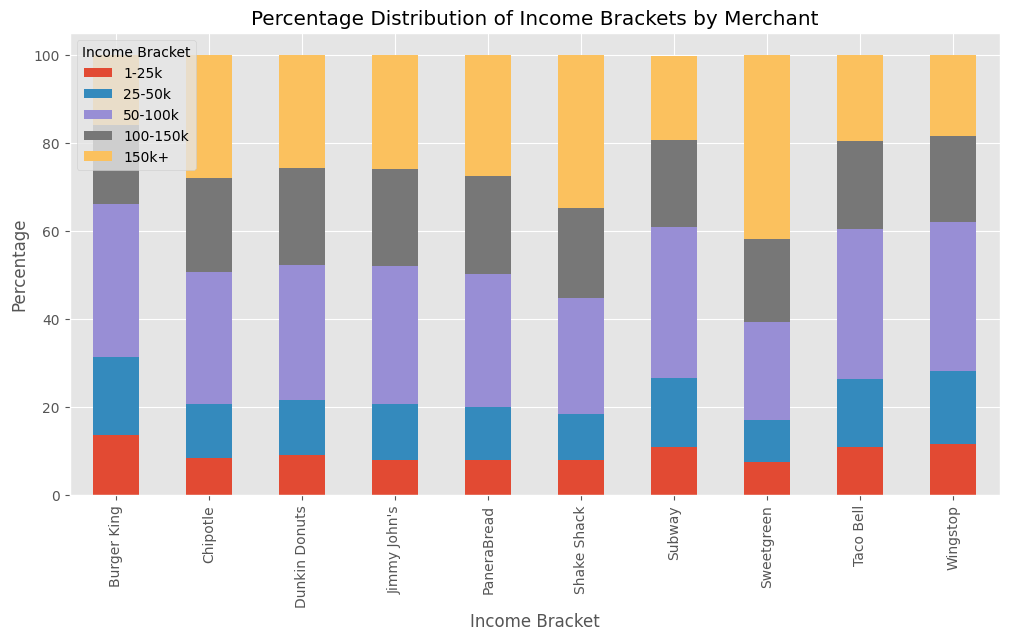

In [61]:
plt.figure(figsize=(10, 6))
pivot_customers.plot(kind='bar', stacked=True)

plt.xlabel('Income Bracket')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Income Brackets by Merchant')
plt.legend(title='Income Bracket', loc='upper left')


plt.show()

#Part 5: Cohort Analysis

In [62]:
merged['cohort'] = merged.groupby(['user_id','merchant_name'])['quarter'] \
                 .transform('min')






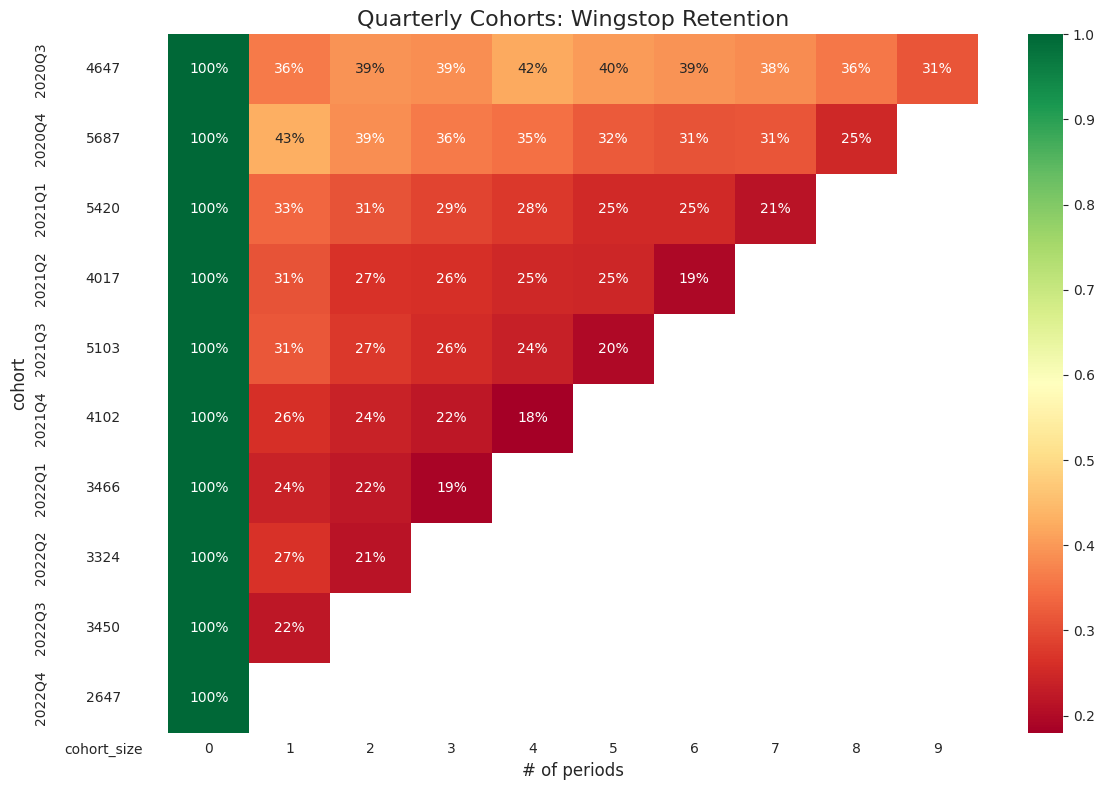

In [63]:
# calculates cohort analysis
WS = RestaurantAnalysis(merged[(merged['merchant_name'] == 'Wingstop')])
trial_graph = WS.cohort_analysis()

#gets size of each cohort
cohort_size = trial_graph.iloc[:,0]
#retention_matrix = cohort_count/ cohort_size
retention_matrix = trial_graph.divide(cohort_size, axis = 0)



with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Quarterly Cohorts: Wingstop Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()

In [64]:
chip = RestaurantAnalysis(merged[merged['merchant_name'] == 'Chipotle'])
chip.cohort_analysis()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cohort,,,,,,,,,,,,,,,,
2019Q1,7991.0,4030.0,3510.0,3275.0,3433.0,3720.0,3652.0,3497.0,3675.0,3630.0,3443.0,3326.0,3246.0,3066.0,2830.0,2587.0
2019Q2,6441.0,2436.0,2143.0,2381.0,2759.0,2662.0,2576.0,2632.0,2600.0,2370.0,2318.0,2324.0,2147.0,2053.0,1785.0,NaN
2019Q3,4846.0,1634.0,1799.0,2088.0,1983.0,1892.0,1940.0,1936.0,1776.0,1731.0,1721.0,1603.0,1498.0,1312.0,NaN,NaN
2019Q4,4505.0,1818.0,1883.0,1755.0,1701.0,1773.0,1748.0,1566.0,1506.0,1522.0,1374.0,1329.0,1171.0,NaN,NaN,NaN
2020Q1,7348.0,3672.0,3045.0,2857.0,2895.0,2733.0,2465.0,2339.0,2363.0,2157.0,1962.0,1829.0,NaN,NaN,NaN,NaN
2020Q2,14249.0,5732.0,5018.0,5017.0,4784.0,4210.0,3952.0,3931.0,3633.0,3408.0,3036.0,NaN,NaN,NaN,NaN,NaN
2020Q3,8172.0,3122.0,3001.0,2844.0,2470.0,2314.0,2238.0,2100.0,1925.0,1730.0,NaN,NaN,NaN,NaN,NaN,NaN
2020Q4,7145.0,2639.0,2365.0,1943.0,1911.0,1880.0,1705.0,1573.0,1359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021Q1,7313.0,2652.0,2033.0,1961.0,1892.0,1673.0,1539.0,1385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#panera = RestaurantAnalysis(merged[merged['merchant_name'] == 'PaneraBread'])
#panera.cohort_analysis()

In [66]:
#TB = RestaurantAnalysis(merged[merged['merchant_name'] == 'Taco Bell'])
#TB.cohort_analysis()





In [67]:
#subway = RestaurantAnalysis(merged[merged['merchant_name'] == 'Subway'])
#subway.cohort_analysis()

In [68]:
#wingstop = RestaurantAnalysis(merged[merged['merchant_name'] == 'Wingstop'])
#wingstop.cohort_analysis()

In [69]:
#SS = RestaurantAnalysis(merged[merged['merchant_name'] == 'Shake Shack'])
#SS.cohort_analysis()

In [70]:
#dunkin = RestaurantAnalysis(merged[merged['merchant_name'] == 'Dunkin Donuts'])
#dunkin.cohort_analysis()

In [71]:
#JJ = RestaurantAnalysis(merged[merged['merchant_name'] == "Jimmy John's"])
#JJ.cohort_analysis()

In [72]:
#SG = RestaurantAnalysis(merged[merged['merchant_name'] == "Sweetgreen"])
#SG.cohort_analysis()

#Part 6: Exclusive Analysis

In [73]:
#find year of merged data
merged['year'] = pd.to_datetime(merged['order_date']).dt.to_period('Y')


In [74]:
#get set of all the restaurants customer been to per year
exclusive_customers = merged.groupby(['user_id','year'])['merchant_name'].apply(set).reset_index()


In [75]:
#Find # of unique restaurants for the year
exclusive_customers['unique'] = [len(i) for i in exclusive_customers['merchant_name']]

exclusive_customers.head()


,user_id,year,merchant_name,unique
0,00003db6-8d9a-3b96-8206-9ca39a2e202c,2020,"{Subway, Wingstop, Chipotle, Burger King}",4
1,00003db6-8d9a-3b96-8206-9ca39a2e202c,2021,"{Subway, Wingstop, Chipotle, Burger King}",4
2,00003db6-8d9a-3b96-8206-9ca39a2e202c,2022,"{Subway, Wingstop, Taco Bell, Chipotle}",4
3,00005c80-8ea9-3cd2-b4bf-97b509ff0b1e,2020,{PaneraBread},1
4,00005c80-8ea9-3cd2-b4bf-97b509ff0b1e,2021,{PaneraBread},1


In [76]:
#Find the # of custoemrs that only went to one store

one_store_customers = exclusive_customers[exclusive_customers['unique'] <= 1]

#isolates name of restaraunt from set
one_store_customers['merchant_name'] = [min(s) for s in one_store_customers['merchant_name']]

#puts into format for the excel
one_store_customers.groupby(["merchant_name","year"])['unique'].sum().reset_index().pivot(index="merchant_name", columns="year", values="unique")

year,2019,2020,2021,2022
merchant_name,,,,
Burger King,327.0,2857.0,2981.0,3328.0
Chipotle,14701.0,28081.0,26784.0,23259.0
Dunkin Donuts,6288.0,5354.0,6011.0,6350.0
Jimmy John's,3084.0,3214.0,4632.0,4997.0
PaneraBread,18314.0,17654.0,16507.0,17157.0
Shake Shack,2448.0,3674.0,3578.0,2854.0
Subway,3172.0,8086.0,6736.0,6818.0
Sweetgreen,3441.0,3459.0,3533.0,4175.0
Taco Bell,3205.0,3941.0,4737.0,5209.0


In [77]:
exclusive_customers = exclusive_customers[exclusive_customers['year'] == '2022']

#allows us to parse the data in a way that gets if a user attended a restaurant for 2022 or not
exclusive_customers['merchant_name'] = [frozenset(i) for i in exclusive_customers['merchant_name']]

#one hot encoding
exclusive_customers = exclusive_customers['merchant_name'].str.join('|').str.get_dummies()


In [78]:
exclusive_customers.head()

,Burger King,Chipotle,Dunkin Donuts,Jimmy John's,PaneraBread,Shake Shack,Subway,Sweetgreen,Taco Bell,Wingstop
2,0,1,0,0,0,0,1,0,1,1
5,0,0,0,0,1,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0
13,0,0,0,1,0,0,0,0,0,0


In [79]:
exclusive_customers.sum()

Burger King      10995
Chipotle         55138
Dunkin Donuts    16184
Jimmy John's     13812
PaneraBread      41700
Shake Shack       8043
Subway           19918
Sweetgreen        7947
Taco Bell        17832
Wingstop         28231
dtype: int64

In [80]:

#instantiate generic matrix
overlap_matrix = pd.DataFrame(0, index=exclusive_customers.columns, columns=exclusive_customers.columns)



# Calculate the percentage matrix via a nested for loop
for index, row in exclusive_customers.iterrows():
    chains_with_customers = row[row != 0].index
    for i in range(len(chains_with_customers)):
        for j in range(i+1, len(chains_with_customers)):
            chain1 = chains_with_customers[i]
            chain2 = chains_with_customers[j]
            overlap_matrix.loc[chain1, chain2] += 1
            overlap_matrix.loc[chain2, chain1] += 1

unique_customers = exclusive_customers.sum()
for k in range(len(exclusive_customers.columns)):
   overlap_matrix.iloc[k, k] = unique_customers[k]



overlap_matrix

,Burger King,Chipotle,Dunkin Donuts,Jimmy John's,PaneraBread,Shake Shack,Subway,Sweetgreen,Taco Bell,Wingstop
Burger King,10995,2800,1276,634,2168,424,2526,103,3105,1761
Chipotle,2800,55138,4571,4442,13752,2777,5784,2199,5717,8494
Dunkin Donuts,1276,4571,16184,746,5130,751,1498,499,1657,945
Jimmy John's,634,4442,746,13812,3547,438,1754,319,1340,1965
PaneraBread,2168,13752,5130,3547,41700,1850,4218,1009,3915,4353
Shake Shack,424,2777,751,438,1850,8043,446,906,705,838
Subway,2526,5784,1498,1754,4218,446,19918,225,3562,3689
Sweetgreen,103,2199,499,319,1009,906,225,7947,259,339
Taco Bell,3105,5717,1657,1340,3915,705,3562,259,17832,3249
Wingstop,1761,8494,945,1965,4353,838,3689,339,3249,28231


In [81]:
#overlap matrix 2 claculates the original matrix into a percentage via a while loop

overlap_matrix2 = pd.DataFrame(0, index=exclusive_customers.columns, columns=exclusive_customers.columns)
k = 0
while k < len(overlap_matrix2):
  j = 0
  while j < len( overlap_matrix2):
    overlap_matrix2.iloc[k, j] = np.round(overlap_matrix.iloc[k, j]/  overlap_matrix.iloc[k, k], 2)
    j = j+1
  k = k+1

overlap_matrix2 = overlap_matrix2 *100
overlap_matrix2

,Burger King,Chipotle,Dunkin Donuts,Jimmy John's,PaneraBread,Shake Shack,Subway,Sweetgreen,Taco Bell,Wingstop
Burger King,100.0,25.0,12.0,6.0,20.0,4.0,23.0,1.0,28.0,16.0
Chipotle,5.0,100.0,8.0,8.0,25.0,5.0,10.0,4.0,10.0,15.0
Dunkin Donuts,8.0,28.0,100.0,5.0,32.0,5.0,9.0,3.0,10.0,6.0
Jimmy John's,5.0,32.0,5.0,100.0,26.0,3.0,13.0,2.0,10.0,14.0
PaneraBread,5.0,33.0,12.0,9.0,100.0,4.0,10.0,2.0,9.0,10.0
Shake Shack,5.0,35.0,9.0,5.0,23.0,100.0,6.0,11.0,9.0,10.0
Subway,13.0,29.0,8.0,9.0,21.0,2.0,100.0,1.0,18.0,19.0
Sweetgreen,1.0,28.0,6.0,4.0,13.0,11.0,3.0,100.0,3.0,4.0
Taco Bell,17.0,32.0,9.0,8.0,22.0,4.0,20.0,1.0,100.0,18.0
Wingstop,6.0,30.0,3.0,7.0,15.0,3.0,13.0,1.0,12.0,100.0


Text(0.5, 36.72222222222221, 'Who also shop at:')

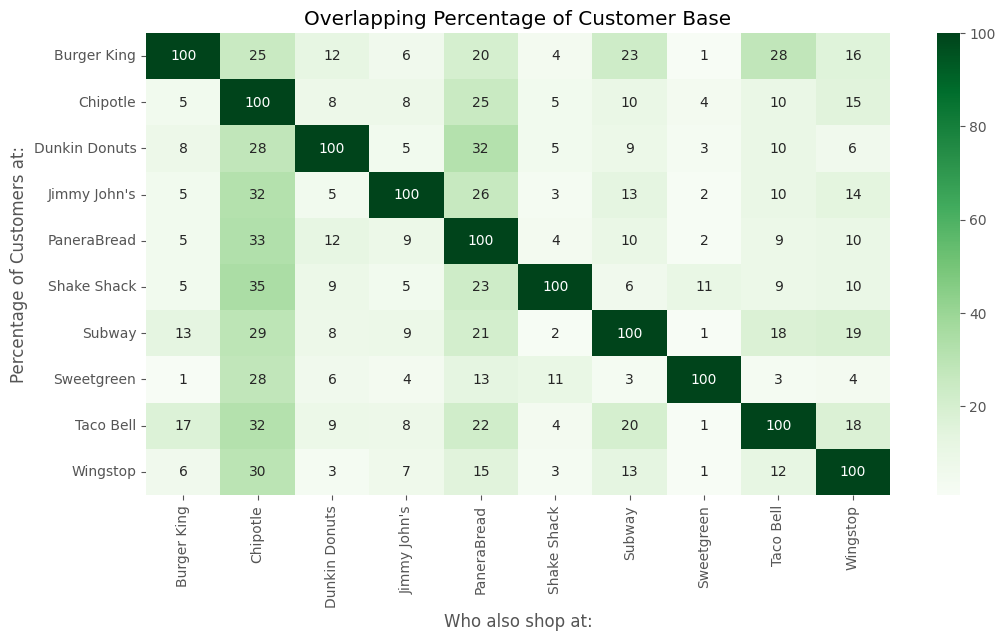

In [82]:
sns.heatmap(overlap_matrix2, cmap="Greens", annot=True, fmt='g')
plt.title("Overlapping Percentage of Customer Base")
plt.ylabel("Percentage of Customers at:")
plt.xlabel("Who also shop at:")

In [83]:
SG_NY = RestaurantAnalysis(merged[(merged['merchant_name'] == "Sweetgreen") & (merged['state_name'] == 'NY')])
#SG_NY.cohort_analysis()


In [84]:
TB_CA= RestaurantAnalysis(merged[(merged['merchant_name'] == "Taco Bell") & (merged['state_name'] == 'CA')])
#TB_CA.cohort_analysis()

In [85]:
wingstop_TX = RestaurantAnalysis(merged[(merged['merchant_name'] == "Wingstop") & (merged['income_bracket'] == '25-50k')])
#wingstop_TX.cohort_analysis()

In [86]:
chipotle_CO = RestaurantAnalysis(merged[(merged['merchant_name'] == "Chipotle") & (merged['state_name'] == 'CO')])
#chipotle_CO.cohort_analysis()

In [87]:
BK_NY= RestaurantAnalysis(merged[(merged['merchant_name'] == "Burger King") & (merged['state_name'] == 'NY')])
#BK_NY.cohort_analysis()

In [88]:
SS_NY = RestaurantAnalysis(merged[(merged['merchant_name'] == "Shake Shack") & (merged['state_name'] == 'NY')])
#SS_NY.cohort_analysis()

In [89]:
JJ_CO = RestaurantAnalysis(merged[(merged['merchant_name'] == "Jimmy John's") & (merged['state_name'] == 'CO')])
#JJ_CO.cohort_analysis()

In [90]:
subway_IA = RestaurantAnalysis(merged[(merged['merchant_name'] == "Subway") & (merged['state_name'] == 'CA')])
#subway_IA.cohort_analysis()

In [91]:
Panera_PA = RestaurantAnalysis(merged[(merged['merchant_name'] == "PaneraBread") & (merged['state_name'] == 'PA')])
#Panera_PA.cohort_analysis()

In [92]:
dunkin_NJ = RestaurantAnalysis(merged[(merged['merchant_name'] == "Dunkin Donuts") & (merged['state_name'] == 'NJ')])
#dunkin_NJ.cohort_analysis()

In [93]:
#gets unique customers for our customer analysis

num_customers = merged.groupby(["merchant_name", "quarter"])["user_id"].nunique().reset_index().pivot(index = "merchant_name", columns = "quarter", values = "user_id").fillna(0)

num_customers

quarter,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
merchant_name,,,,,,,,,,,,,,,,
Burger King,0.0,0.0,0.0,608.0,1842.0,3161.0,3332.0,3112.0,3561.0,3925.0,3988.0,4817.0,4681.0,5082.0,4897.0,4570.0
Chipotle,7991.0,10471.0,10792.0,11557.0,16779.0,28371.0,27001.0,27808.0,30885.0,31977.0,29199.0,29098.0,29644.0,28367.0,27231.0,24713.0
Dunkin Donuts,5612.0,6207.0,6517.0,6439.0,6229.0,6206.0,8212.0,8721.0,9260.0,10480.0,10887.0,10661.0,10130.0,10867.0,9970.0,10084.0
Jimmy John's,2021.0,2199.0,2196.0,2252.0,2816.0,3078.0,3474.0,3352.0,5291.0,6620.0,6600.0,6206.0,6492.0,6797.0,6742.0,5920.0
PaneraBread,11936.0,11759.0,11710.0,12631.0,12214.0,13071.0,17094.0,18630.0,18512.0,17988.0,17656.0,18542.0,18097.0,18163.0,18523.0,20092.0
Shake Shack,1363.0,1631.0,1430.0,1461.0,1630.0,2967.0,3524.0,3761.0,3880.0,3719.0,3383.0,3250.0,3041.0,2953.0,2946.0,2983.0
Subway,1298.0,2174.0,2338.0,2425.0,4213.0,7248.0,8747.0,7304.0,7289.0,8531.0,8149.0,8112.0,8584.0,8917.0,8551.0,7897.0
Sweetgreen,2221.0,2594.0,2714.0,2511.0,2920.0,1832.0,2840.0,2664.0,2792.0,3401.0,3686.0,3603.0,3770.0,4191.0,3880.0,3576.0
Taco Bell,1916.0,2070.0,2196.0,2395.0,2835.0,4269.0,5251.0,5289.0,7037.0,7713.0,7884.0,8083.0,7051.0,8363.0,8294.0,8436.0


In [97]:
#Predicting if a User will return in 6 months or less (2 periods)

In [96]:
'''
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(

            # 1st hidden layer
            torch.nn.Linear(num_features, 25),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(15, num_classes),
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits
'''



'\nclass PyTorchMLP(torch.nn.Module):\n    def __init__(self, num_features, num_classes):\n        super().__init__()\n\n        self.all_layers = torch.nn.Sequential(\n                \n            # 1st hidden layer\n            torch.nn.Linear(num_features, 25),\n            torch.nn.ReLU(),\n\n            # 2nd hidden layer\n            torch.nn.Linear(25, 15),\n            torch.nn.ReLU(),\n\n            # output layer\n            torch.nn.Linear(15, num_classes),\n        )\n\n    def forward(self, x):\n        logits = self.all_layers(x)\n        return logits\n'

In [95]:
'''

for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

'\n\nfor epoch in range(num_epochs):\n\n    model = model.train()\n    for batch_idx, (features, labels) in enumerate(train_loader):\n\n        logits = model(features)\n\n        loss = F.cross_entropy(logits, labels)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n'